In [1]:
is_on_colab = False

if is_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    

In [2]:
#%cd /content/drive/MyDrive/git/optimal_control_jax
#%pip install jaxopt tensor-canvas

In [3]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' # prevent JAX from allocating all GPU memory

In [4]:
from functools import partial

import numpy as np
import pandas as pd
import math
import plotly.express as px
import matplotlib.pyplot as plt 
from ipywidgets import interact, interactive

import tensorflow as tf
from tensorflow.keras.models import Model

if not is_on_colab:
    tf.config.set_visible_devices([], 'GPU')   # workaround on mac M1 

In [5]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp
from jax.experimental import jax2tf

from jax_control_algorithms.plot_helpers import plot_states, plot_output_comparison, plot_state_comparison
from load_video import load_dataset_single_video, load_video
from uncontrolled_pendulum import *
from pendulum_nn_models import *
from pendulum_nn_helper import *

jax.config.update('jax_enable_x64', True)

In [6]:
pdf_scenarios = pd.DataFrame([
        {'scenario' : 'redapple',    'vfile' : 'pendulum_videos/redapple_480p.mov'},
        {'scenario' : 'zucchini',    'vfile' : 'pendulum_videos/zucchini_480p.mov'},
        {'scenario' : 'star',        'vfile' : 'pendulum_videos/star_480p.mov'},
        {'scenario' : 'tree1',        'vfile' : 'pendulum_videos/tree1_480p.mov'},
        {'scenario' : 'tree2',        'vfile' : 'pendulum_videos/tree2_480p.mov'},
        {'scenario' : 'leaf',        'vfile' : 'pendulum_videos/leaf_480p.mov'},

    
        {'scenario' : 'apple',    'vfile' : 'pendulum_videos/ApfelKurz480p.mov'},
        {'scenario' : 'banana',   'vfile' : 'pendulum_videos/pendel_banane_480p.mov'},
        {'scenario' : 'oliveoil', 'vfile' : 'pendulum_videos/pendel_olive_oil_480p_short.mov'},
])

pdf_scenarios

,scenario,vfile
0,redapple,pendulum_videos/redapple_480p.mov
1,zucchini,pendulum_videos/zucchini_480p.mov
2,star,pendulum_videos/star_480p.mov
3,tree1,pendulum_videos/tree1_480p.mov
4,tree2,pendulum_videos/tree2_480p.mov
5,leaf,pendulum_videos/leaf_480p.mov
6,apple,pendulum_videos/ApfelKurz480p.mov
7,banana,pendulum_videos/pendel_banane_480p.mov
8,oliveoil,pendulum_videos/pendel_olive_oil_480p_short.mov


# Load data from a video file



In [7]:
scenario = 'zucchini'

In [10]:
vfile = pdf_scenarios[ pdf_scenarios.scenario == scenario ]['vfile'].iloc[0]
print(f'loading {vfile}')

x_train, mean_picture, T_batch, picture_shape, max_time, dt = load_dataset_single_video(
    vfile, 
    target_size = [96, 160], 
    is_remove_meanpic = True, 
    dt = 1/60.0
)

def show_picture(i : int):    
    plt.imshow(x_train[0,i,:,:,:])
    plt.show()


interactive( show_picture, i = (0,x_train.shape[1]-2) )

loading pendulum_videos/zucchini_480p.mov


interactive(children=(IntSlider(value=806, description='i', max=1613), Output()), _dom_classes=('widget-intera…

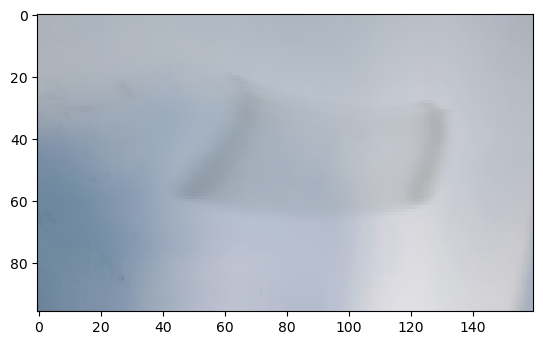

In [11]:
plt.imshow( mean_picture[0] )

# With pendulum model constraints

In [12]:
pe_autoencoder = build_physically_informed_model2(
    lambda_ml = 1.0,
    lambda_mv = 1.0,
    lambda_pendulum_fit = 1.0,
    lambda_stability = 0.01,
    
    wy1 = 1.0, wy2 = 1.0, wx1 = 100.0, wx2 = 100.0, 

    lambda_exp = 1.5,
    
    picture_shape=picture_shape, 
    max_time=max_time, dt=dt
)

In [13]:
# pe_autoencoder = tf.keras.models.load_model('trained_models/XX')

In [14]:
# test
#tmp = pe_autoencoder.predict(x_train)
tmp = pe_autoencoder(x_train)
# print([ x.shape if x is not None else None  for x in tmp ])
img_seq_dec, J_, Y_measurement, Y_dot_measurement, e_delta, X_hat, theta_hat, J_pendulum_fit = tmp
del tmp
J_, theta_hat, np.rad2deg(X_hat[:,0,:])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-04 15:01:44.896752: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.2598487], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[4., 0., 0.]], dtype=float32)>,
 array([[0., 0.]], dtype=float32))

In [15]:
pe_autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 * 1),
    loss=[ tf.keras.losses.MeanSquaredError(), None, None, None, None, ],
    jit_compile=False
)
pe_autoencoder.summary()

Model: "pendulum_model_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_model_4CNN_layers_1  (1615, 128)              516176    
 28out (Sequential)                                              
                                                                 
 decoder_model_4CNNT_layers_  (1615, 96, 160, 3)       519911    
 128out (Sequential)                                             
                                                                 
 embedding_to_position_model  (1615, 1)                2209      
  (Sequential)                                                   
                                                                 
 position_to_embedding_model  (1615, 128)              2336      
  (Sequential)                                                   
                                                                 
 image_to_position_delta_mod  (1614, 1) 

Epoch 1/10
Instructions for updating:
Use fn_output_signature instead
1/1 [==============================] - 12s 12s/step - loss: 1.3743 - output_1_loss: 0.1145
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 0.9414 - output_1_loss: 0.1142
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.1564 - output_1_loss: 0.1140
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.7575 - output_1_loss: 0.1138
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.3597 - output_1_loss: 0.1135
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.1550 - output_1_loss: 0.1133
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.2479 - output_1_loss: 0.1130
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 0.2864 - output_1_loss: 0.1127
Epoch 9/10
1/1 [==============================] - 5s 5s/step - loss: 0.2935 - output_1_loss: 0.1124
Epoch 10/10
1/1 [======================

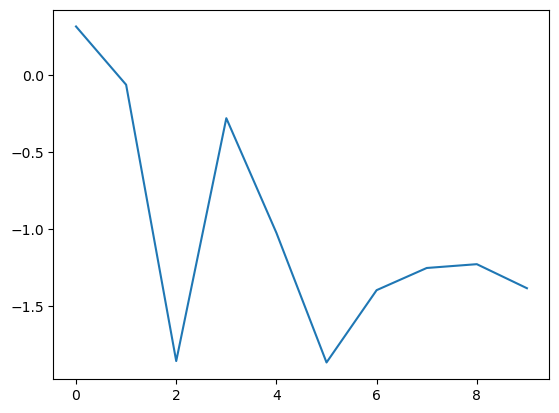

In [16]:
history = pe_autoencoder.fit( x_train, x_train, epochs=10, verbose=True )
plt.plot( np.log(history.history['loss']) )

In [17]:
pe_autoencoder.save('trained_models/tmp')

INFO:tensorflow:Assets written to: trained_models/tmp/assets


INFO:tensorflow:Assets written to: trained_models/tmp/assets


theta=[ 3.998304843902588, 0.00418627867475152, -0.004181076772511005 ]
J_pendulum_fit = 0.007962079718708992
R^2 = -31.17622677286147  20*log10(R^2) = -79.99999999999999


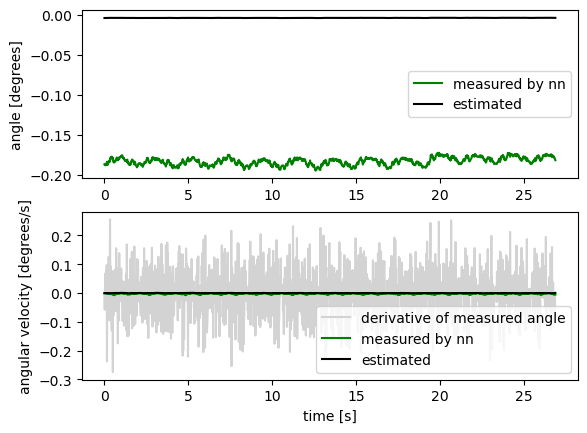

In [18]:
plot_time_eval(pe_autoencoder, x_train, T_batch, dt)

# Export video

In [ ]:
from export_pendulum_animation import build_video

vfile = pdf_scenarios[ pdf_scenarios.scenario == scenario ]['vfile'].iloc[0]
print(f'exporting video from {vfile}')

#vfile = 'pendulum_videos/ApfelKurz480p.mov'
animation = build_video(0, vfile, T_batch, X_hat)
 
# displaying animation with auto play and looping
animation.ipython_display(fps = 60, loop = True, autoplay = True)